# Fourier Ring Correlation - Demonstration

This notebook demonstrates how the FRC function is used and what the results look like.
We perform 3 experiments to understand the FRC behavior:

    - Noise Experiment
    - Blur Experiment
    - Blur + Noise Experiment

In [1]:
%pylab inline
from skimage import data, color
from scipy.signal import convolve
from metrics import get_frc

Populating the interactive namespace from numpy and matplotlib


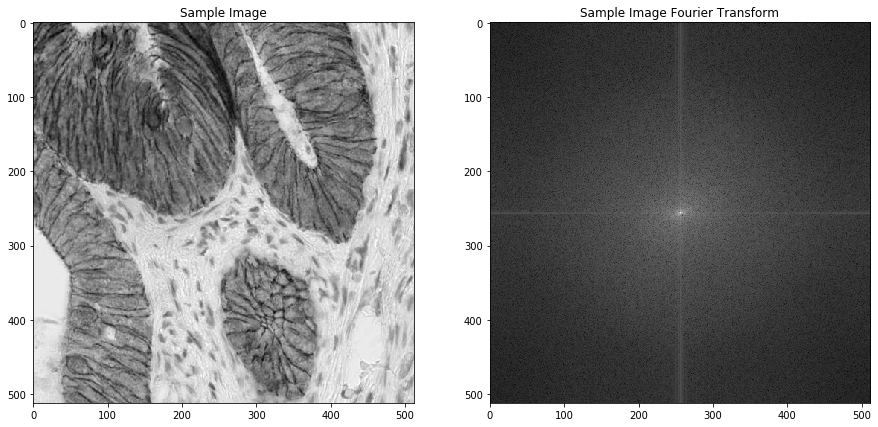

In [2]:
# set the image
img = color.rgb2gray(data.immunohistochemistry())
img_f = np.fft.fft2(img)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Sample Image')
ax[1].imshow(abs(np.fft.fftshift(img_f))**0.1, cmap='gray')
ax[1].set_title('Sample Image Fourier Transform')
plt.show()

# Noise Experiment

Let's add different levels of noise to the reference image and check the FRC results.

### Generate a set of noisy images with different SNRs

In [3]:
# set different noise levels to add
noise_stds = [0.05, 0.1, 0.2, 0.5]
imgs_noisy = np.array([np.random.normal(loc=img, scale=std) for std in noise_stds])

imgs_noisy_f = np.fft.fft2(imgs_noisy)

### Show the noisy images

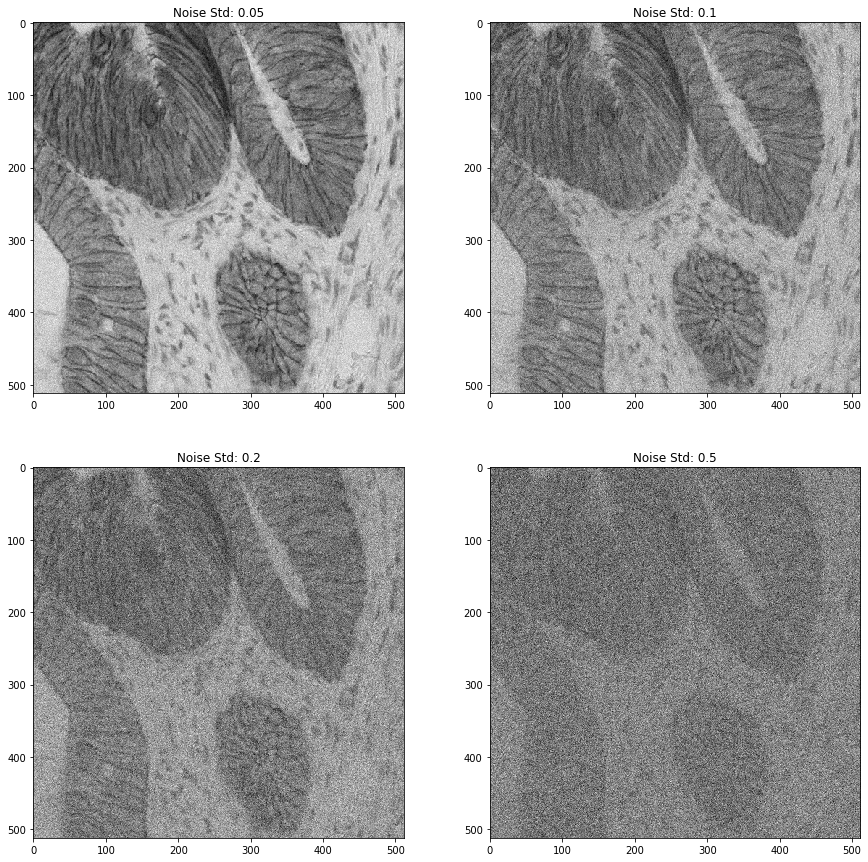

In [4]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(imgs_noisy[2*i+j], cmap='gray')
        ax[i,j].set_title('Noise Std: {}'.format(noise_stds[2*i+j]))
plt.show()

### Show the noisy images in the Fourier Domain

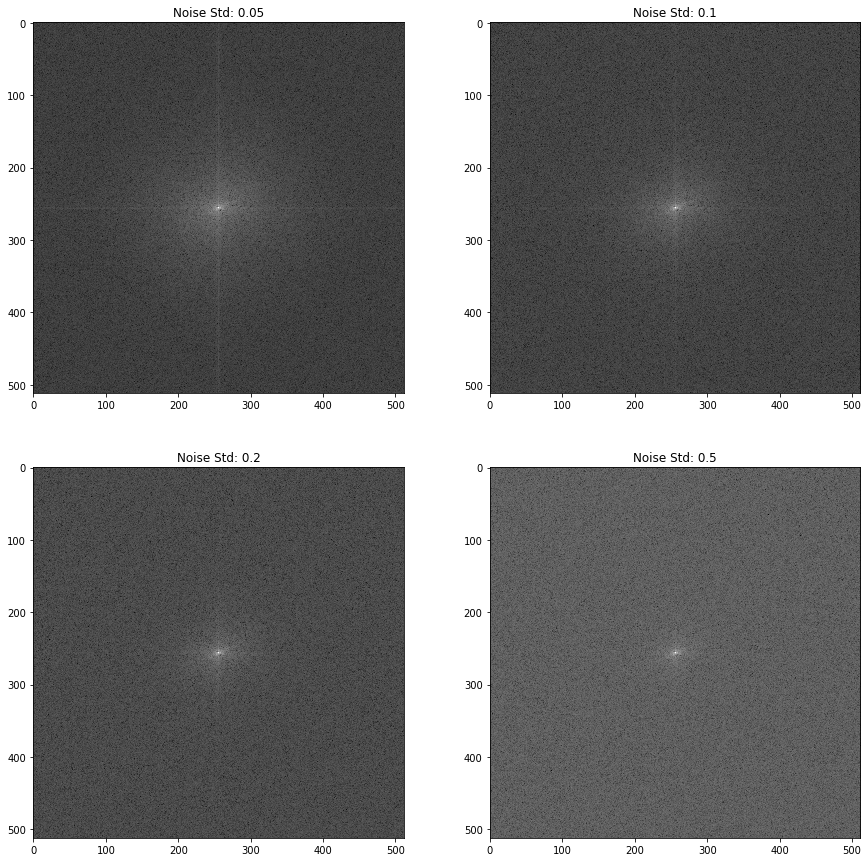

In [5]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(abs(np.fft.fftshift(imgs_noisy_f[2*i+j]))**0.1, cmap='gray')
        ax[i,j].set_title('Noise Std: {}'.format(noise_stds[2*i+j]))
plt.show()

### Compute FRCs between the original and noisy images with both corner={False,True} options.

In [6]:
frcs_nocorner = [get_frc(img, img_noisy) for img_noisy in imgs_noisy]
frcs_corner = [get_frc(img, img_noisy, corners=True) for img_noisy in imgs_noisy]

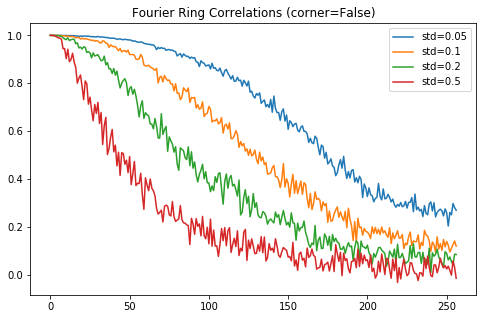

In [7]:
plt.figure(figsize=(8,5))
for i in range(len(frcs_nocorner)):
    plt.plot(frcs_nocorner[i].real, label='std={}'.format(noise_stds[i]))
plt.legend()
plt.title('Fourier Ring Correlations (corner=False)')
plt.show()

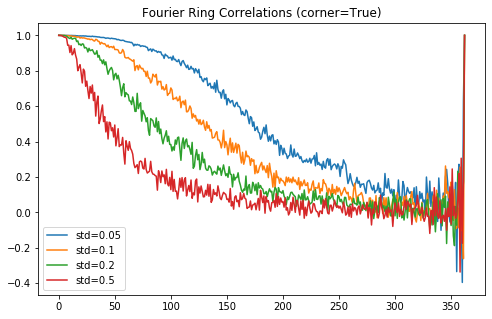

In [8]:
plt.figure(figsize=(8,5))
for i in range(len(frcs_corner)):
    plt.plot(frcs_corner[i].real, label='std={}'.format(noise_stds[i]))
plt.legend()
plt.title('Fourier Ring Correlations (corner=True)')
plt.show()

## Comment:
corner=True option seems to generate unreliable results around the outermost rings. It is probably because there are not enough samples inside them to generate a good estimate for the correlation. Also note that we plot the real part of the frc. One could ask, why not absolute? The reason is, normalized correlation takes values between -1 and 1. We definitely don't want to confuse negative correlation with positive one.

# Blur Experiment

Let's apply different levels blur to the reference image and check the FRC results.

### Generate a set of blurry images with different PSFs

In [9]:
# set the size of the box (or rect, or moving averager) filters
box_sizes = [2, 4, 6, 10]
imgs_blurry = np.array([convolve(img, 1/size**2*np.ones((size,size)), mode='same') for size in box_sizes])

imgs_blurry_f = np.fft.fft2(imgs_blurry)
filters_f = [np.fft.fft2(1/size**2*np.ones((size,size)), img.shape) for size in box_sizes]

### Show the blurry images

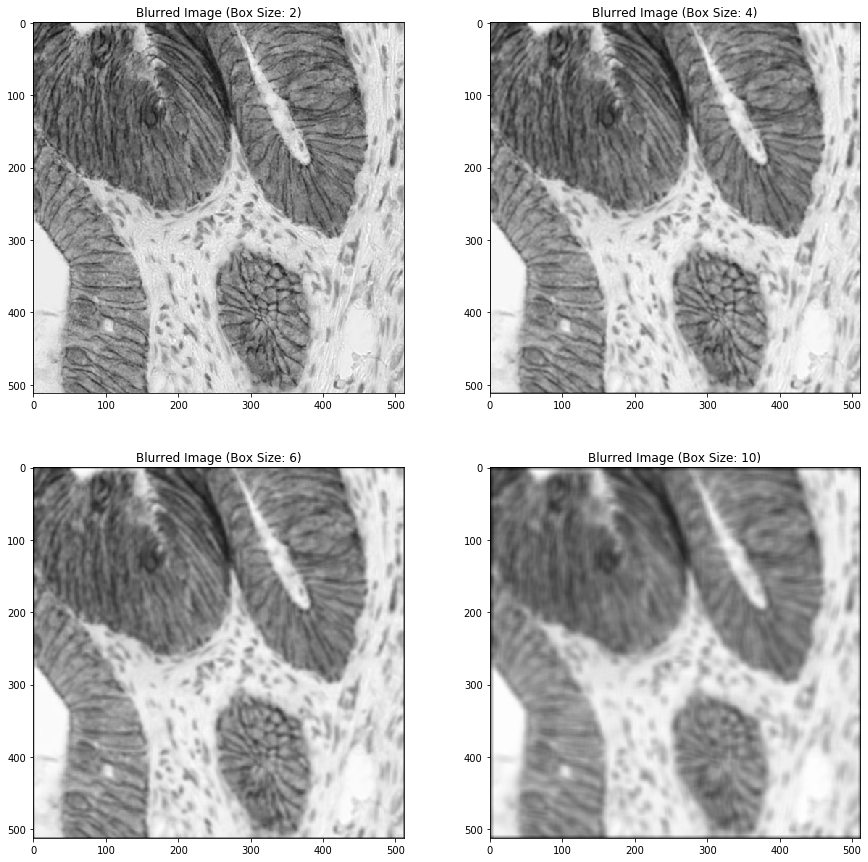

In [10]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(imgs_blurry[2*i+j], cmap='gray')
        ax[i,j].set_title('Blurred Image (Box Size: {})'.format(box_sizes[2*i+j]))
plt.show()

### Show the blurry images in Fourier Domain

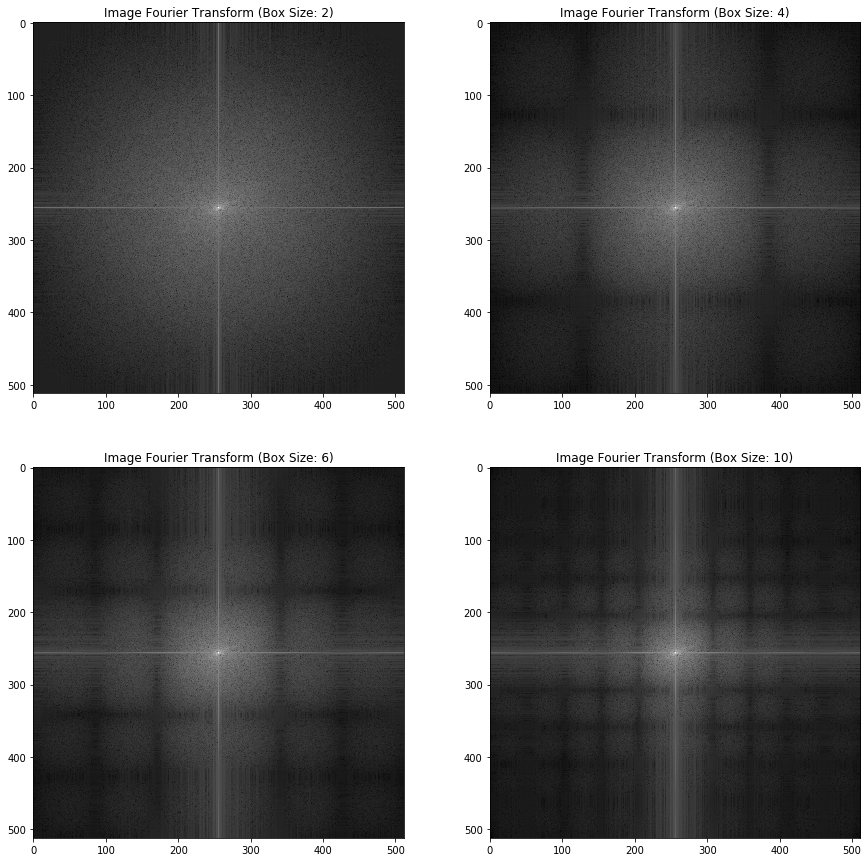

In [11]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(abs(np.fft.fftshift(imgs_blurry_f[2*i+j]))**0.1, cmap='gray')
        ax[i,j].set_title('Image Fourier Transform (Box Size: {})'.format(box_sizes[2*i+j]))
plt.show()

### Show the filters in Fourier Domain (i.e. the transfer functions)

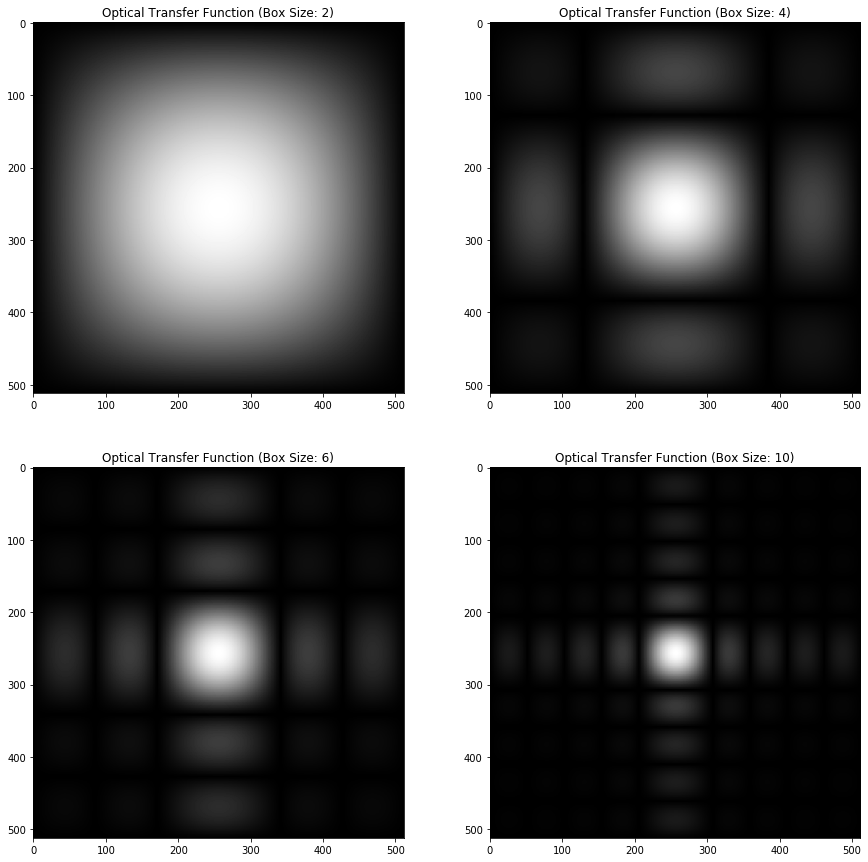

In [12]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(abs(np.fft.fftshift(filters_f[2*i+j])), cmap='gray')
        ax[i,j].set_title('Optical Transfer Function (Box Size: {})'.format(box_sizes[2*i+j]))
plt.show()

### Compute FRCs between the original and blurry images with both corner={False,True} options.

In [13]:
frcs_nocorner = [get_frc(img, img_blurry) for img_blurry in imgs_blurry]
frcs_corner = [get_frc(img, img_blurry, corners=True) for img_blurry in imgs_blurry]

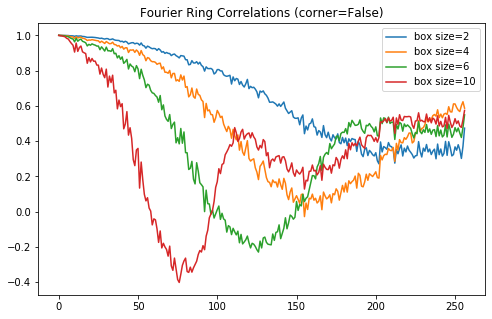

In [14]:
plt.figure(figsize=(8,5))
for i in range(len(frcs_nocorner)):
    plt.plot(frcs_nocorner[i].real, label='box size={}'.format(box_sizes[i]))
plt.legend()
plt.title('Fourier Ring Correlations (corner=False)')
plt.show()

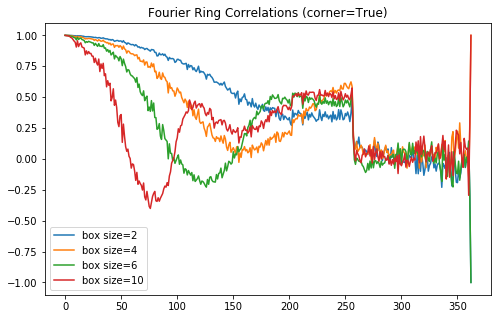

In [15]:
plt.figure(figsize=(8,5))
for i in range(len(frcs_corner)):
    plt.plot(frcs_corner[i].real, label='box size={}'.format(box_sizes[i]))
plt.legend()
plt.title('Fourier Ring Correlations (corner=True)')
plt.show()

## Comment:
The shapes of the FRC curves are correlated with the transfer functions of the filters, which makes sense. One problem with the shapes is that there are ups and downs (it's not monotonically decreasing), and this may cause ambiguities when we apply a threshold to find the resolution. 

# Blur+Noise Experiment

Let's apply both blur and noise to the images and check the FRC curves. This is a more realistic scenario.

In [16]:
noise_stds = [0.05, 0.2]
box_sizes = [2, 6]
imgs_degraded = np.zeros([len(noise_stds),len(box_sizes)]+list(img.shape))

for i,std in enumerate(noise_stds):
    for j, size in enumerate(box_sizes):
        imgs_degraded[i,j] = (
            np.random.normal(convolve(img, 1/size**2*np.ones((size,size)), mode='same'), scale=std)
        )
        
imgs_degraded_f = np.fft.fft2(imgs_degraded)

### Show the degraded images

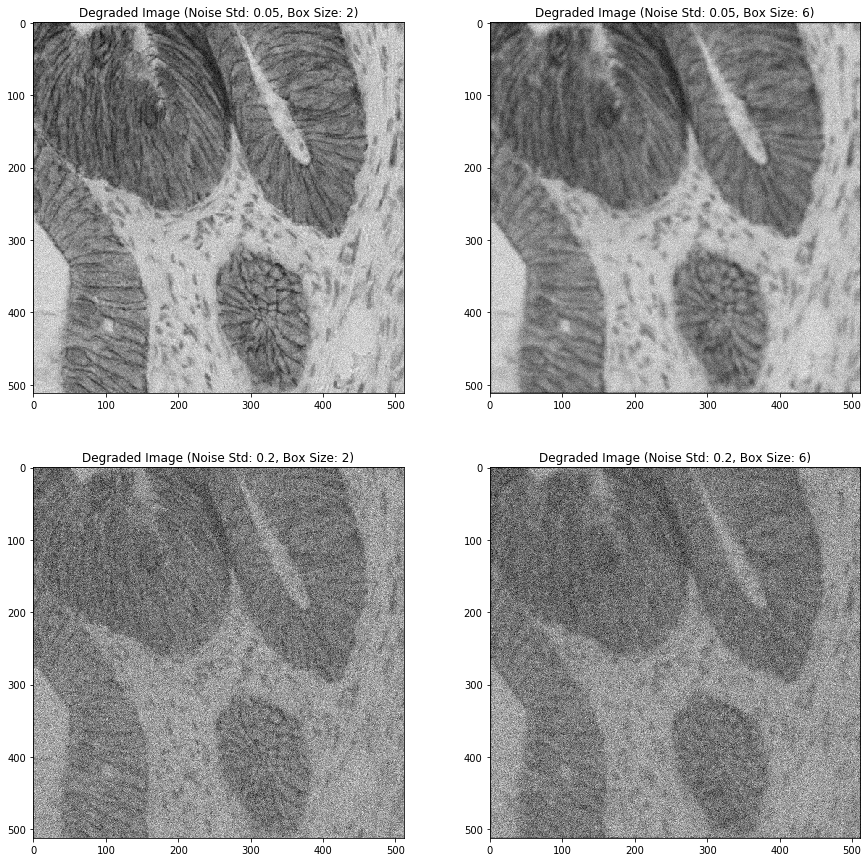

In [17]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(imgs_degraded[i,j], cmap='gray')
        ax[i,j].set_title('Degraded Image (Noise Std: {}, Box Size: {})'.format(noise_stds[i], box_sizes[j]))
plt.show()

### Show the degraded images in Fourier Domain

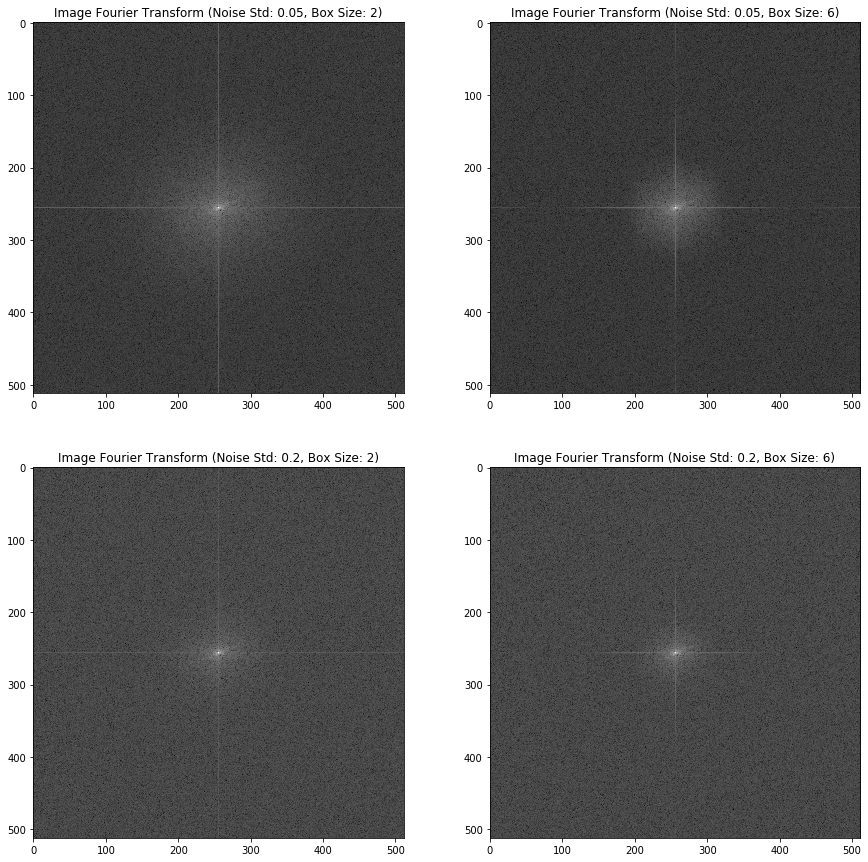

In [18]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(abs(np.fft.fftshift(imgs_degraded_f[i,j]))**0.1, cmap='gray')
        ax[i,j].set_title('Image Fourier Transform (Noise Std: {}, Box Size: {})'.format(noise_stds[i], box_sizes[j]))
plt.show()

### Compute FRCs between the original and degraded images

In [19]:
frcs_nocorner = []
for i in range(len(noise_stds)):
    for j in range(len(box_sizes)):
        frcs_nocorner.append(get_frc(img, imgs_degraded[i,j]))

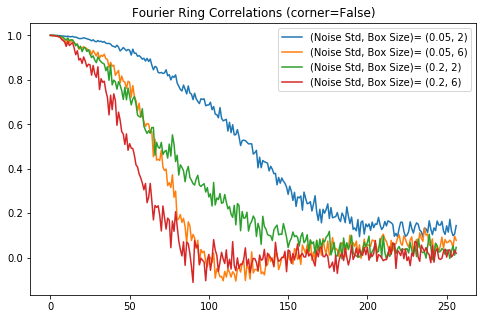

In [20]:
plt.figure(figsize=(8,5))
for i in range(len(noise_stds)):
    for j in range(len(box_sizes)):
        plt.plot(frcs_nocorner[2*i+j].real, label='(Noise Std, Box Size)= ({}, {})'.format(noise_stds[i], box_sizes[j]))
plt.legend()
plt.title('Fourier Ring Correlations (corner=False)')
plt.show()

## Comment:
In this more realistic scenario, we see that the non-monotonicity problem is gone. Even when the noise std is as low as 0.05, it suppresses the sidelobes for the filter with box size=6 as can be seen from the orange curve.

# FRC on Torch

In [21]:
%pylab inline
from skimage import data, color
from scipy.signal import convolve
from metrics import get_frc
import torch
import metrics

Populating the interactive namespace from numpy and matplotlib


/home/berk/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['size', 'convolve', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


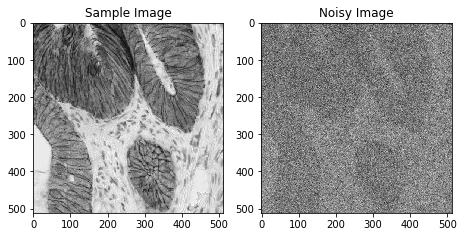

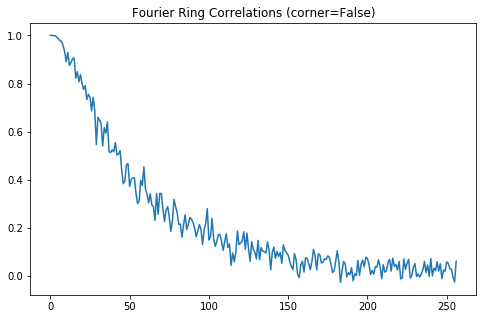

In [22]:
##FRC using numpy

# set the image
img = color.rgb2gray(data.immunohistochemistry())

# set a noise level to add
noise_stds = 0.5
img_noisy = np.random.normal(loc=img, scale=noise_stds)

fig, ax = plt.subplots(1, 2, figsize=(7.5,5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Sample Image')
ax[1].imshow(img_noisy, cmap='gray')
ax[1].set_title('Noisy Image')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(get_frc(img, img_noisy).real)
plt.title('Fourier Ring Correlations (corner=False)')
plt.show()

In [23]:
def roll_n(X, axis, n):
    f_idx = tuple(slice(None, None, None) if i != axis else slice(0, n, None) for i in range(X.dim()))
    b_idx = tuple(slice(None, None, None) if i != axis else slice(n, None, None) for i in range(X.dim()))
    front = X[f_idx]
    back = X[b_idx]
    return torch.cat([back, front], axis)

def batch_fftshift2d(x):
    real = x.real
    imag = x.imag
    for dim in range(1, len(real.size())):
        n_shift = real.size(dim)//2
        if real.size(dim) % 2 != 0:
            n_shift += 1  # for odd-sized images
        real = roll_n(real, axis=dim, n=n_shift)
        imag = roll_n(imag, axis=dim, n=n_shift)
    return torch.stack((real, imag), -1)  # last dim=2 (real&imag)

def ringsum_torch(im, corners=False):
    '''
    Given a 2d square array, calculate the sum of elements for each concentric
    ring of 1 pixel width and return the array of sums.

    Parameters
    ----------
    im : ndarray
        Elements to sum.
    corners : bool, optional
        If set to True, the largest ring diameter will be set to corner-to-corner
        distance; otherwise edge-to-edge.

    Returns
    -------
    ndarray
        1d array whose n^th element is the sum of input's elements inside the
        n^th ring.
    '''
    assert im.shape[0] == im.shape[1], 'input should be square'
    imsize = im.shape[0]
    r = torch.arange(imsize) - imsize//2
    # generate a meshgrid where the origin is the midpoint of the array.
    # if the array length is even, the lower right point will be the origin.
    [xx,yy] = torch.meshgrid(r,r)
    xx = xx.double()
    yy = yy.double()
    radii = torch.sqrt(xx**2 + yy**2)

    maxrad = int(torch.max(radii)) if corners else imsize//2
    sums = torch.zeros(maxrad+1)

    for radius in range(maxrad+1):
        sums[radius] = torch.sum(im[torch.where(torch.BoolTensor((radii < radius+0.5) & (radii >= radius - 0.5)))])

    return sums


/home/berk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/aten/src/ATen/native/Copy.cpp:162.)


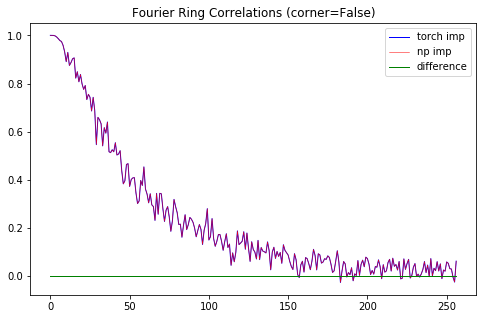

False


In [24]:
##FRC using torch
corners = False
img_torch = torch.from_numpy(img.astype(float))
img_noisy_torch = torch.from_numpy(img_noisy.astype(float))

im1f = batch_fftshift2d(torch.fft.fftn(img_torch[None,:,:]))
im2f = batch_fftshift2d(torch.fft.fftn(img_noisy_torch[None,:,:]))

im1f = torch.complex(im1f[0,:,:,0], im1f[0,:,:,1])  
im2f = torch.complex(im2f[0,:,:,0], im2f[0,:,:,1])   

frc = (ringsum_torch(im1f * im2f.conj(), corners=corners) /
    torch.sqrt(
        ringsum_torch(torch.abs(im1f)**2, corners=corners) *
        ringsum_torch(torch.abs(im2f)**2, corners=corners)))


plt.figure(figsize=(8,5))
plt.plot(frc,label = 'torch imp', linewidth = 1, color= 'blue')
plt.plot(get_frc(img, img_noisy).real, label = 'np imp',linewidth = 0.5, color='red')
plt.plot(frc - get_frc(img, img_noisy).real, label = 'difference',linewidth = 1, color='green')
plt.title('Fourier Ring Correlations (corner=False)')
plt.legend()
plt.show()

print(frc == get_frc(img, img_noisy).real)

torch.Size([257, 2])
(257,)
complex128


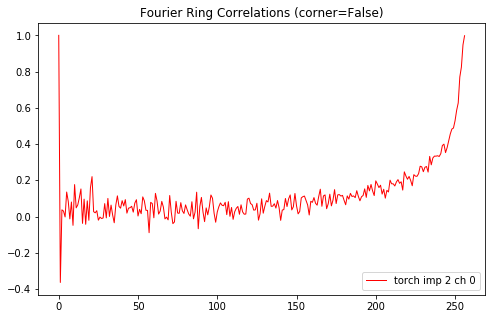

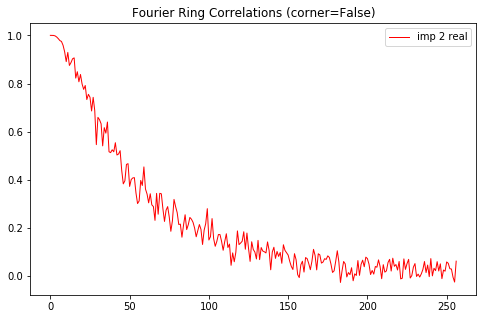

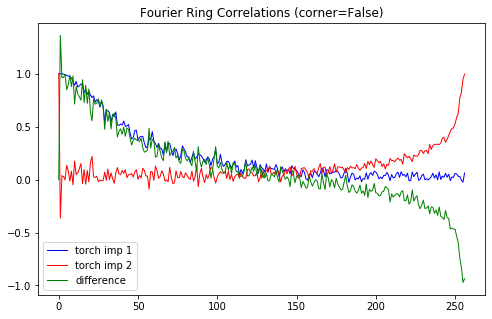

In [25]:
print(metrics.get_frc_torch(img_torch, img_noisy_torch).shape)
print(get_frc(img, img_noisy).shape)
print(get_frc(img, img_noisy).dtype)

plt.figure(figsize=(8,5))
plt.plot(metrics.get_frc_torch(img_torch, img_noisy_torch)[:,0], label = 'torch imp 2 ch 0',linewidth = 1, color='red')
# plt.plot(metrics.get_frc_torch(img_torch, img_noisy_torch)[:,1], label = 'torch imp 2 ch 1',linewidth = 1, color='red')
plt.title('Fourier Ring Correlations (corner=False)')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(np.real(get_frc(img, img_noisy)), label = 'imp 2 real',linewidth = 1, color='red')
# plt.plot(metrics.get_frc_torch(img_torch, img_noisy_torch)[:,1], label = 'torch imp 2 ch 1',linewidth = 1, color='red')
plt.title('Fourier Ring Correlations (corner=False)')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(frc,label = 'torch imp 1', linewidth = 1, color= 'blue')
plt.plot(metrics.get_frc_torch(img_torch, img_noisy_torch)[:,0], label = 'torch imp 2',linewidth = 1, color='red')
plt.plot(frc - metrics.get_frc_torch(img_torch, img_noisy_torch)[:,0], label = 'difference',linewidth = 1, color='green')
plt.title('Fourier Ring Correlations (corner=False)')
plt.legend()
plt.show()